## Importando bibliotecas

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import imageio

# Importando banco de imagens

In [3]:
conjunto1 = []
for i in range(1, 7):
  path = "/content/drive/MyDrive/Faculdade/2022 1/Visão Computacional/Projeto/Base de Imagens/c1-img" + str(i) + ".jpeg"
  conjunto1.append(cv2.imread(path, 0))

conjunto2 = []
for i in range(1, 6):
  path = "/content/drive/MyDrive/Faculdade/2022 1/Visão Computacional/Projeto/Base de Imagens/c2-img" + str(i) + ".jpeg"
  conjunto2.append(cv2.imread(path, 0))

conjunto3 = []
for i in range(1, 6):
  path = "/content/drive/MyDrive/Faculdade/2022 1/Visão Computacional/Projeto/Base de Imagens/c3-img" + str(i) + ".tiff"
  conjunto3.append(cv2.imread(path, 0))

conjunto4 = []
for i in range(1, 6):
  path = "/content/drive/MyDrive/Faculdade/2022 1/Visão Computacional/Projeto/Base de Imagens/c4-img" + str(i) + ".tiff"
  conjunto4.append(cv2.imread(path, 0))

banco_imagens = [conjunto1,conjunto2,conjunto3,conjunto4]

In [4]:
def plotar_conjunto(conjunto, num_conjunto):
    """
    Argumentos:
        numero_intervalos: conjunto com fotos carregadas
        sigma: quantidade de fotos no conjunto

    Retornos: 
        vetor_sigmas: Vetor de sigmas respectivo a cada nível da oitava
    """
    plt.figure(figsize=[18, 8])
    for i, img in enumerate(conjunto):
      plt.subplot(2, 3, i+1); plt.imshow(img, 'gray'); plt.title('Imagem ' + str(i+1)); plt.axis('off')
    plt.suptitle('Conjunto de Imagens ' +str(num_conjunto)) 
    plt.show()

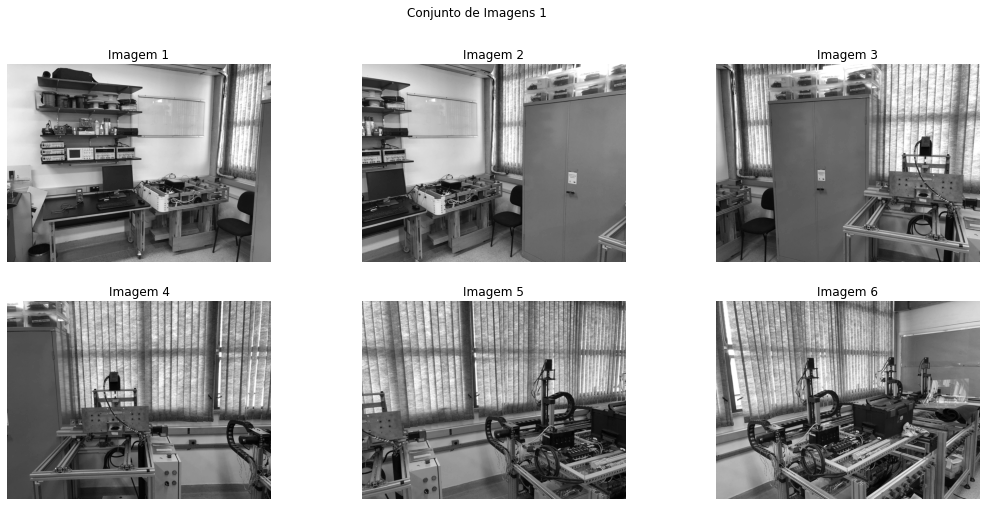

In [5]:
plotar_conjunto(conjunto1, 1)

# Implementação do algoritmo SIFT

## Costrução do espaço-escala

O espaço-escala de uma imagem é definido como uma função, $L(x, y, σ)$, que é produzida a partir da convolução de uma gaussiana de escala variável, $G(x, y, σ)$, com uma imagem de entrada, $I(x, y)$: 


<br/><div align="center"> $L(x, y, σ) = G(x, y, σ) ∗ I(x, y)$</div>

<br/>

sendo $G(x, y, σ) = \frac{1}{ 2πσ^2 } e^{−(x^2+y^2)/2σ^2}$

<br/>

Para detectar keypoints ​​no espaço-escala (Lowe, 1999) propôs 
usar a função Diferença de Gaussianas convolvida com a imagem,
$D(x, y, σ)$, que pode ser calculado a partir da diferença de duas escalas próximas separadas por um fator multiplicativo constante k:

<br/>
<div align="center">$D(x, y, σ) = (G(x, y, kσ) − G(x, y, σ)) ∗ I(x, y)$</div>
<div align="center">$ = L(x, y, kσ) − L(x, y, σ)$</div>
<br/>

Construindo $D(x, y, σ)$:

* Convolução da imagem inicial com Gaussianas separadas por uma constante $k$

* σ deve dobrar a cada oitava do espaço-escala

* Dividir cada oitava do espaço-escala por um número inteiro de intervalos, $s$

* $k = 2^{1/s}$

* Produzir $s+3$ imagens para cada oitava para a detecção cobrir toda a oitava

* As imagens adjacentes são subtraídas para produzir as imagens de Diferença da Gaussiana

* No final da oitava fazer um downsappling das duas imagens do topo pegando cada segundo pixel em cada linha e coluna 

In [6]:
def calcular_valores_sigma(numero_intervalos, sigma):
    """
    Argumentos:
        numero_intervalos: número de saltos entre as imagens da oitava
        sigma: quantidade de borramento inicial

    Retornos: 
        vetor_sigmas: Vetor de sigmas respectivo a cada nível da oitava
    """
    # Cálculo da constante que separa as escalas
    k = 2 ** (1/numero_intervalos)

    # Construir vetor de sigmas
    vetor_sigmas = []

    # Sigma inicial na primeira posição do vetor
    vetor_sigmas.append(sigma)

    # 
    for i in range(1, numero_intervalos+3):
        sigma_anterior = (k ** (i-1)) * sigma
        proximo_sigma = k * sigma_anterior

        # Adiciona sigma calculado no vetor
        vetor_sigmas.append((proximo_sigma**2 - sigma_anterior**2)**(0.5))
    
    return vetor_sigmas

In [7]:
def construir_oitava(imagem_inicial, numero_niveis, sigma):
    """
    Argumentos:
        imagem_inicial: imagem de entrada
        numero_niveis: quantidade de imagens em uma oitava
        sigma: valor de borramento inicial
        
    Retorno:
        niveis_oitava: retorna vetor com os niveis da oitava 
    """  
    # s, número inteiro que divide a oitava 
    numero_intervalos = numero_niveis - 1

    # Produzir s+3 imagens para cada oitava
    niveis_oitava = np.zeros((numero_intervalos+3, imagem_inicial.shape[0], imagem_inicial.shape[1]))

    # Primeiro nível da oitava é a imagem inicial
    niveis_oitava[0] = imagem_inicial
    
    # Calcula o valor de sigma para cada gaussiana da oitava
    vetor_sigmas = calcular_valores_sigma(numero_intervalos, sigma)
    
    # Convolução da imagem inicial com Gaussianas separadas por uma constante k
    for i in range(1, numero_intervalos+3):
        niveis_oitava[i] = ndi.gaussian_filter(niveis_oitava[i-1], sigma=vetor_sigmas[i])
        
    return niveis_oitava

In [8]:
def contruir_piramide_gaussiana(img, numero_oitavas, niveis_por_oitava, sigma):
    """
    Argumentos:
        img: imagem de entrada
        numero_oitavas: quantidade de oitavas na piramide
        niveis_por_oitava: quantidade de imagens em uma oitava
        sigma: valor de borramento inicial
        
    Retorno:
        niveis_oitava: retorna vetor com os niveis da oitava 
    """ 
    
    # Suponha que a imagem de entrada tenha um desfoque de sigma=0.5, 
    # faça upsample e desfoque para que a imagem inicial
    # da pirâmide tenha um borrão de sigma = 1,6
    img_interp = ndi.zoom(img, 2, order=1)
    sig = (sigma**2 - 1)**(0.5)
    imagem_inicial = ndi.gaussian_filter(img_interp, sigma=sig)     
    
    # Contruir vetor da piramide
    piramide_gaussiana = []
    
    # Calcula as oitavas
    for i in range(numero_oitavas):
        if i==0:
            # Base da oitava é a imagem inicial
            # Já vem calculada da oitava anterior
            imagem_inicial = imagem_inicial
        else:
            # no final da oitava fazer um downsappling das duas imagens do topo 
            # pegando cada segundo pixel em cada linha e coluna 
            ultimo_nivel = piramide_gaussiana[i-1][-3]  
            imagem_inicial = ultimo_nivel[::2, ::2]
        
        # Constroi a oitava
        niveis_oitava = construir_oitava(imagem_inicial, niveis_por_oitava, sigma)

        # Adiciona a oitava no vetor da pirâmide
        piramide_gaussiana.append(niveis_oitava)
        
    return piramide_gaussiana

In [9]:
def construir_diferenca_gaussianas(piramide_gaussiana):
    """
    Argumentos:
        piramide_gaussiana: 
        
    Retorno:
        niveis_oitava: retorna vetor com os niveis da oitava 
    """ 
    
    numero_oitavas = len(piramide_gaussiana)
    piramide_dog = []

    # A primeira diferença é dada por out[i] = a[i+1] - a[i] ao longo do eixo dado
    # diferenças maiores são calculadas usando diff recursivamente
    # O eixo 0 possui cada uma das oitavas, então:
    # DOG[i] = nivel_oitava[i+1] - nivel_oitava[i]
    for mat_octave in piramide_gaussiana:
        mat_diff = np.diff(mat_octave, axis=0)
        piramide_dog.append(mat_diff)
            
    return piramide_dog  

In [10]:
def plot_piramide_gaussiana(piramide_gaussiana):
    """
    Plota uma figura com a pirâmide gaussiana, um nível de oitava
    em cada coluna e uma linha em cada oitava

    Argumentos:
        piramide_gaussiana: recebe um vetor com uma pirâmide gaussiana

    Retorno:
        -
    """
    
    numero_oitavas = len(piramide_gaussiana)
    niveis_por_oitava = len(piramide_gaussiana[0])-2
    
    sigma_base = sigma
    plt.figure(figsize=(20, 25))
    for i in range(numero_oitavas):        
        for k in range(niveis_por_oitava):
            s = sigma_base*np.power(2, k/(niveis_por_oitava-1))
            plt.subplot(numero_oitavas, niveis_por_oitava, 4*i+k+1)
            plt.imshow(piramide_gaussiana[i][k], 'gray')
            plt.title('Oitava = %d\n nivel = %d\n escala = %.2f' % (i, k, s))
        sigma_base = s

def plot_dog_pyr(dog_pyr):
    '''Visualize SIFT difference of Gaussians pyramid.'''
    
    num_octaves = len(dog_pyr)
    num_levels_per_octave = len(dog_pyr[0])-1
    
    first_figsize = 16
    sigma_base = sigma
    plt.figure(figsize=(20, 25))
    for i in range(num_octaves):
        for k in range(num_levels_per_octave):
            s = sigma_base*np.power(2, k/(num_levels_per_octave-1))
            plt.subplot(numero_oitavas, num_levels_per_octave, 4*i+k+1)
            plt.imshow(dog_pyr[i][k], 'gray')
            plt.title('Oitava = %d\n nivel = %d\n escala = %.2f' % (i, k, s))
        sigma_base = s     

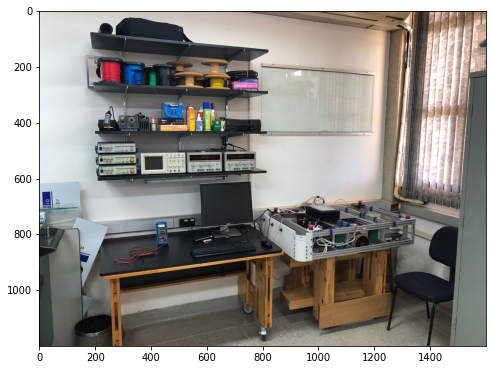

In [11]:
img = plt.imread('/content/drive/MyDrive/Faculdade/2022 1/Visão Computacional/Projeto/Base de Imagens/c1-img1.tiff',0)
img = (img-np.min(img))/(np.max(img)-np.min(img))

plt.figure(figsize=[8,8])
plt.imshow(img, 'gray')

In [12]:
# Mudei o caminho só pra ler aqui no meu Drive
#img = cv2.imread('/content/drive/MyDrive/Projeto/Base de Imagens/c1-img1.tiff',0)

#plt.figure(figsize=[8,8])
#plt.imshow(img, 'gray')

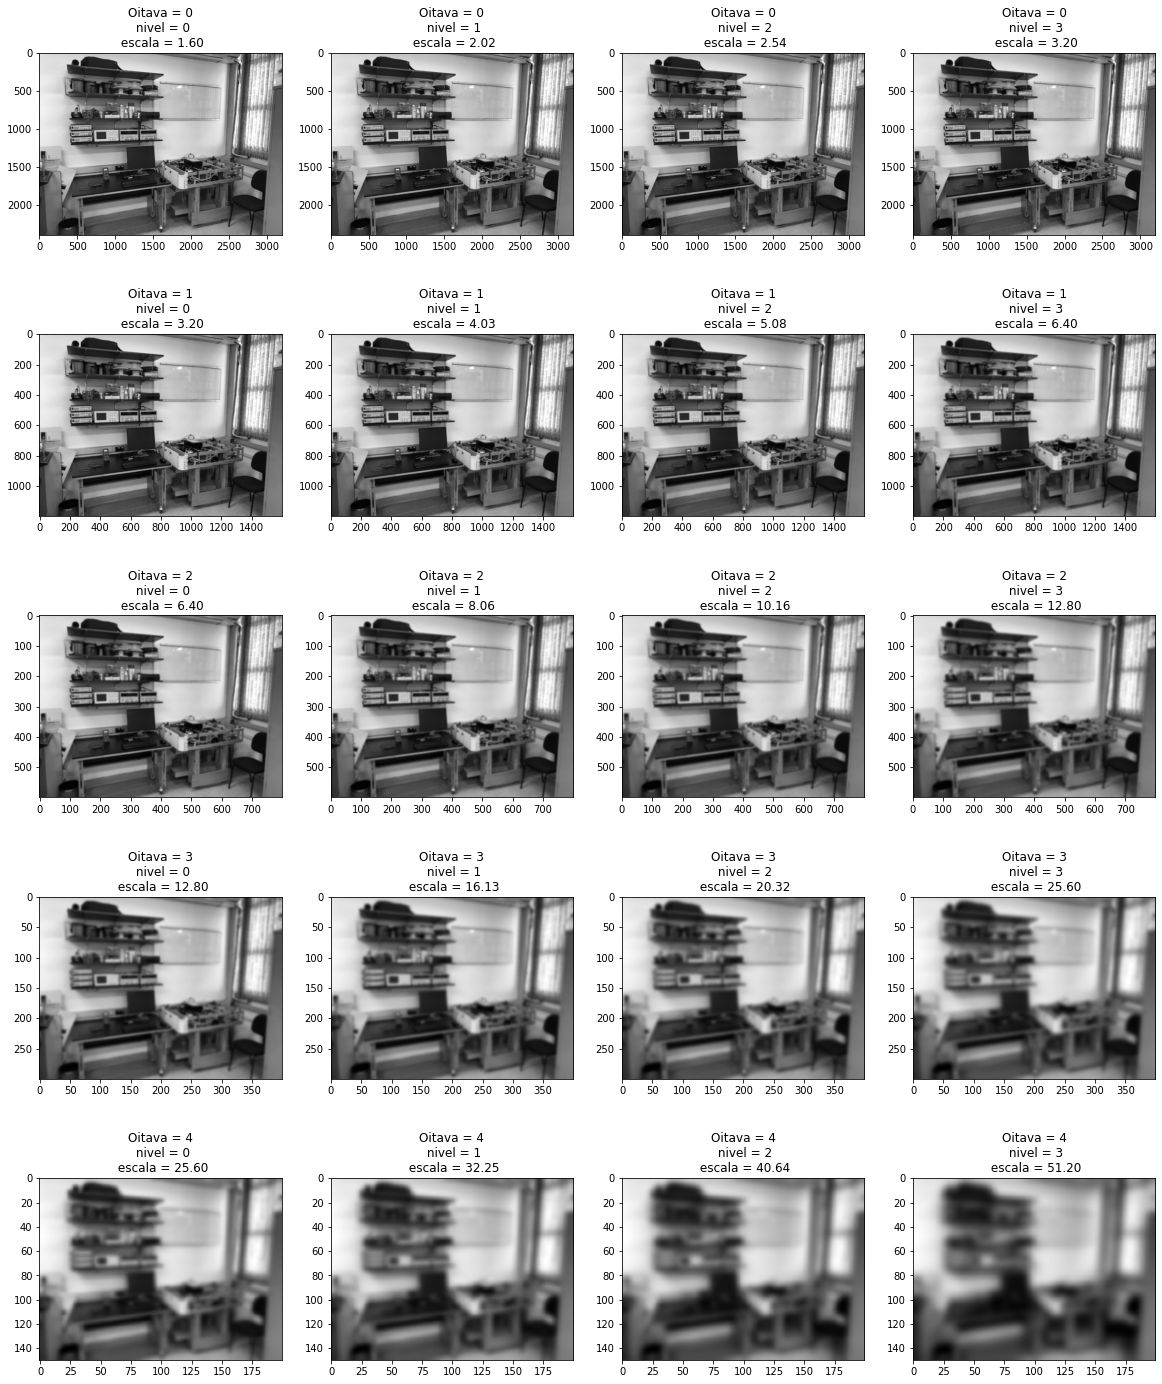

In [13]:
numero_oitavas = 5    # Number of octaves so that smallest image has size 2**5=32
sigma = 1.6                                         # Best sigma according to Lowe
niveis_por_oitava = 4                           # Best number of suboctaves according to Lowe

piramide_gaussiana = contruir_piramide_gaussiana(conjunto1[0], numero_oitavas, niveis_por_oitava, sigma)
diferenca_de_gaussianas = construir_diferenca_gaussianas(piramide_gaussiana)

plot_piramide_gaussiana(piramide_gaussiana)

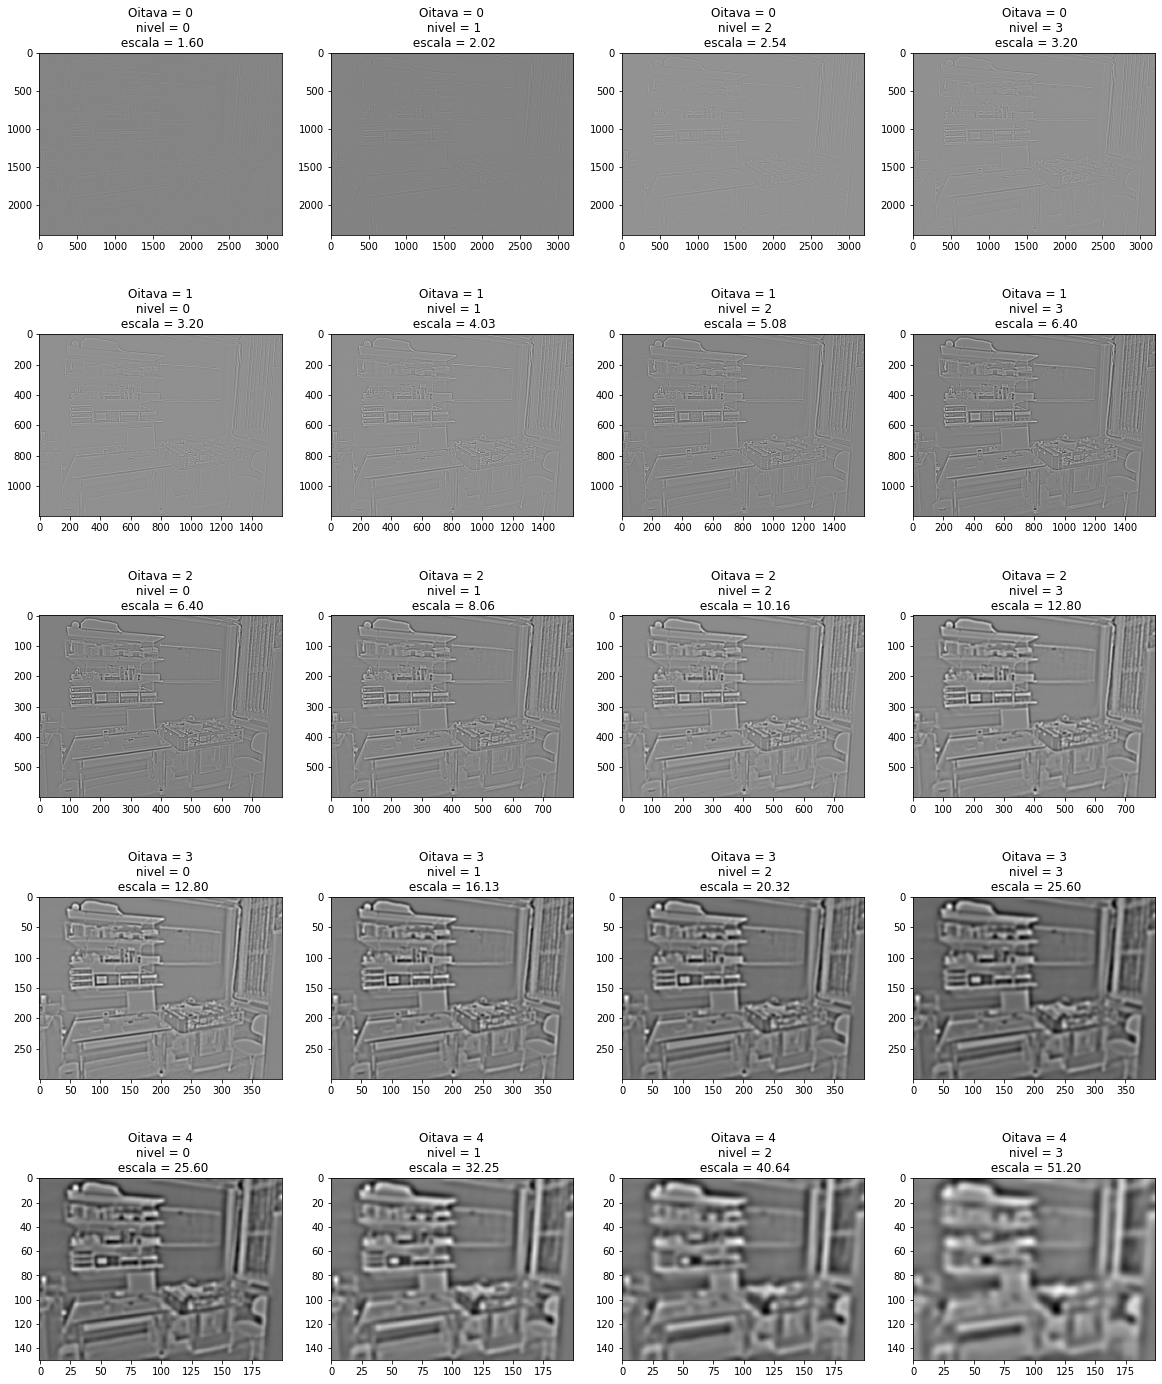

In [14]:
plot_dog_pyr(diferenca_de_gaussianas)

## Localização de Keypoints

Para localizar os máximos e mínimos de $D(x,y,\sigma)$, para cada imagem na piramide de diferenças gaussianas, percorremos cada ponto e comparamos ele com  os seus 26 vizinhos em escalas adjacentes. O pixel é selecionado apenas se é maior que todos os seus vizinhos ou menor que todos os seus vizinhos. 

Observação: Ainda precisa ver a questão das imagens da base e topo de cada oitava.

In [15]:
def vizinhos_3D(img,img_acima,img_abaixo, i, j, d=1):

    #Pega os vizinhos e coloca num array 1x9
    patch_atual = img[i-d:i+d+1, j-d:j+d+1].flatten()
    #Remove o pixel atual
    vizinhos_atual = np.hstack((patch_atual[:len(patch_atual)//2], patch_atual[len(patch_atual)//2+1:] ))
    #Pega os vizinhos acima 
    vizinhos_acima = img_acima[i-d:i+d+1, j-d:j+d+1].flatten()
    #Pega os vizinhos abaixo
    vizinhos_abaixo = img_abaixo[i-d:i+d+1, j-d:j+d+1].flatten()
    #Concatena esses arrays em um único array 1x26
    vizinhos = np.concatenate((vizinhos_atual,vizinhos_acima,vizinhos_abaixo), axis = None)

    return vizinhos

In [16]:
def localizacao_keypoints(diferenca_de_gaussianas):
  keypoints = []
  numero_oitavas = len(diferenca_de_gaussianas)
  #Depois queria tirar uma dúvida contigo sobre esse -2 haha
  niveis_por_oitava = len(diferenca_de_gaussianas[0])-2
  #Percorrendo cada oitava e cada nivel (Mas tem que ver como fica na base e topo de cada oitava)
  for i in range(1,numero_oitavas-1):        
    for j in range(1,niveis_por_oitava-1):
      #Pega os patchs atuais, acima e abaixo
      img = diferenca_de_gaussianas[i][j]
      img_acima = diferenca_de_gaussianas[i][j+1]
      img_abaixo = diferenca_de_gaussianas[i][j-1]
      #Percorre os pixels da imagem
      for x in range(1,img.shape[0]-1):
        for y in range(1,img.shape[1]-1):
          #Faz uma lista com os valores dos 26 vizinhos
          vizinhos = vizinhos_3D(img,img_acima,img_abaixo,x,y)
          #Faz a escolha se o ponto é maior ou menor do que seus vizinhos
          if img[x,y] > max(vizinhos) or img[x,y] < min(vizinhos):
            #Rotula esse índice como um keypoint
            keypoints.append([x,y])
  #Escolhe os únicos keypoints iniciais
  keypoints = np.unique(np.array(keypoints), axis=0)

  return keypoints #Lista de keypoints (i,j) em I

In [17]:
pixels = localizacao_keypoints(diferenca_de_gaussianas)

In [18]:
resultRGB = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)

for i in range(len(pixels)):
  resultRGB[pixels[i][0]-2:pixels[i][0]+2,pixels[i][1]-2:pixels[i][1]+2]=255,0,0

plt.figure(figsize=[8,8])
plt.imshow(resultRGB, 'gray')

error: ignored

## Refinamento de Keypoints


Para fazer o refinamento desses pontos de acordo com a escala, para cada keypoint fazemos um fit através de uma quádrica. Fazendo a expansão de taylor da função espaço-escala $D(x,y,\sigma)$, obtemos $D(\vec{x})=D+\dfrac{\partial D}{\partial \vec{x}}\vec{x}+\dfrac{\vec{x}}{2}\dfrac{\partial^2D}{\partial \vec{x}^2}\vec{x}$ onde $\vec{x}=(x,y,\sigma)$, $D = D(x,y,\sigma)$ e todas as derivadas são avaliadas em $(x,y,\sigma)$. O extremante local é encontrado derivando $D(\vec{x})$ em relação à $\vec{x}$ e igualando a zero, onde obtemos $\vec{x}^*=\bigg(\dfrac{-\partial^2D}{\partial \vec{x}^2}\bigg)^{-1}\dfrac{\partial D}{\partial \vec{x}}$. 

In [ ]:
def refinamento_keypoints(keypoints):
  #para cada keypoint
    #encontrar o x^* acima
      #adicionar x^* ao keypoint??
  return None #novos keypoints

## Determinação da orientação

In [ ]:
def determinar_orientação(keypoints):
  #para cada keypoint (x,y)
    #calcular m e \theta
      #formar um histograma de orientações de uma região do keypoint usando m e \theta
      #interpolar o valor ao redor do maior pico e determinar a orientação
      #a magnitude é a magnitude do gradiente no ponto
  return None #keypoints representados por orientação e escala

## Descritor de pontos

In [ ]:
def descritor(keypoints):
  #para cada keypoint
    #selecionar uma vizinhança e fazer o peso através de uma janela gaussiana
      #calcular a magnitude e orientação do gradiente nessa regiao
        #criar uma subregião contento os descritores????        
  return None #descritores